In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [121]:
# Paquetes del tio guapo
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

In [122]:
# Cosas Enric
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
# Use Tensorboard for network visualization & debugging
from tensorflow.keras.callbacks import TensorBoard
import sklearn.metrics
# import regularizer(s)
from tensorflow.keras.regularizers import l1, l2, l1_l2
# import Dropout
from tensorflow.keras.layers import Dropout
# import activation seperately
from tensorflow.keras.layers import Activation

## Import the  non standarized data

In [123]:
V52 = pd.read_csv('V52_data_no_standarized.csv')

V52 = V52.drop(columns=['Date'])
V52 = V52.rename(columns={'Unnamed: 0': 'Date'})

## AVOID NaNs.... (Hablar con enrique)

In [124]:
# just take the longest continuous data from V52_data

longest_sequence = 0
current_sequence = 0
start_index = None
end_index = None
current_start_index = None

for i, value in enumerate(V52['Wsp_44m']):
    if pd.notna(value):
        if current_sequence == 0:
            current_start_index = i
        current_sequence += 1
    else:
        if current_sequence > longest_sequence:
            longest_sequence = current_sequence
            start_index = current_start_index
            end_index = i - 1
        current_sequence = 0

# Check for the last sequence in case it reaches the end of the column
if current_sequence > longest_sequence:
    longest_sequence = current_sequence
    start_index = current_start_index
    end_index = len(V52) - 1

print("Longest sequence without NaN values:", longest_sequence)
print("Start index:", start_index)
print("End index:", end_index)

# Create a new dataframe with the longest sequence
V52_data_longest = V52.iloc[start_index:end_index+1]

# set the date as index
V52_data_longest = V52_data_longest.set_index('Date')

Longest sequence without NaN values: 1346
Start index: 28435
End index: 29780


In [125]:
# Just take out NaN from V52
V52_no_nan = V52.dropna(axis=0, how='any', inplace=False)

## Split the data into train and test

In [126]:
train_size = int(len(V52_no_nan) * 0.8)
test_size = len(V52_no_nan) - train_size

train, test = V52_no_nan.iloc[0:train_size], V52_no_nan.iloc[train_size:len(V52_no_nan)]


print(train.shape, test.shape)

(29686, 11) (7422, 11)


## Scale the data

Enrique.... si puedes pensar una manera mejor seria la polla

In [127]:
from sklearn.preprocessing import RobustScaler

# packag for ignore warnings
import warnings
warnings.filterwarnings('ignore')

f_colums = ['ActPow', 'ActPow_std']    # X columns
 
# For easy standardization of the data
f_transformer = RobustScaler()
power_transformer = RobustScaler()


# Transform the train and test
f_transformer = f_transformer.fit(train[f_colums].to_numpy())  # Fit for standardization of X
power_transformer = power_transformer.fit(train[['ActPow']])   # Fit for standardization of Y

# Apply to the train and test
train.loc[:, f_colums] = f_transformer.transform(train[f_colums].to_numpy())
train['ActPow'] = power_transformer.transform(train[['ActPow']])

test.loc[:, f_colums] = f_transformer.transform(test[f_colums].to_numpy())
test['ActPow'] = power_transformer.transform(test[['ActPow']])

## Divide the data into Sequences

In [128]:
# Cutting of the time series into sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
       v = X.iloc[i: (i + time_steps)].to_numpy()
       Xs.append(v)
       ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# We are creating the sequences for the time step defined

In [129]:
TIME_STEPS = 144 # Venga lets take a hole day

# Now create the acrual training and test sequences

X_train, y_train = create_sequences(train[['ActPow', 'ActPow_std']], train['ActPow'], time_steps=TIME_STEPS)
X_test, y_test = create_sequences(test[['ActPow', 'ActPow_std']], test['ActPow'], time_steps=TIME_STEPS)

In [130]:
# Print the shape to see if everything is ok
# [samples, time_steps, n_features]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(29542, 144, 2) (29542,)
(7278, 144, 2) (7278,)


## TUFFE MODEL - FOLLOWING VIDEO STEPS

## MODEL CREATION

In [131]:
pad_value = 999
no_features = 2

model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))

# First LSTM layer with L2 regularization
model.add(LSTM(50,
               return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_initializer='random_uniform',
               bias_initializer='zeros',
               kernel_regularizer=l2(0.01),  # L2 regularization
               dtype='float32'))

# Activation layer
model.add(Activation('relu'))


# Second LSTM layer with L2 regularization
model.add(LSTM(10,
               activation='relu',
               kernel_regularizer=l2(0.01),  # L2 regularization
               dtype='float32'))


# Output Layer
model.add(Dense(1, activation='linear'))

In [132]:
# comile the model to be ready for training
model.compile(loss='mean_squared_error', optimizer='adam')

## RUN THE MODEL

In [133]:
history = model.fit(
                    X_train, y_train, 
                    epochs=30,
                    batch_size=300,
                    validation_split = 0.2,  # para validar el modelo sin utilizar los datos de train
                    shuffle=False
                     )

Epoch 1/30
79/79 [==============================] - 38s 416ms/step - loss: 0.3644 - val_loss: 0.1941
Epoch 2/30
79/79 [==============================] - 31s 393ms/step - loss: 0.1264 - val_loss: 0.0746
Epoch 3/30
79/79 [==============================] - 30s 384ms/step - loss: 0.0477 - val_loss: 0.0277
Epoch 4/30
79/79 [==============================] - 31s 389ms/step - loss: 0.0179 - val_loss: 0.0107
Epoch 5/30
79/79 [==============================] - 28s 362ms/step - loss: 0.0072 - val_loss: 0.0047
Epoch 6/30
79/79 [==============================] - 26s 333ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 7/30
79/79 [==============================] - 26s 325ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/30
79/79 [==============================] - 25s 316ms/step - loss: 0.0012 - val_loss: 9.4105e-04
Epoch 9/30
79/79 [==============================] - 27s 337ms/step - loss: 7.8732e-04 - val_loss: 6.2564e-04
Epoch 10/30
79/79 [==============================] - 28s 356ms/step - loss: 5.4

## PLOT THE LOST

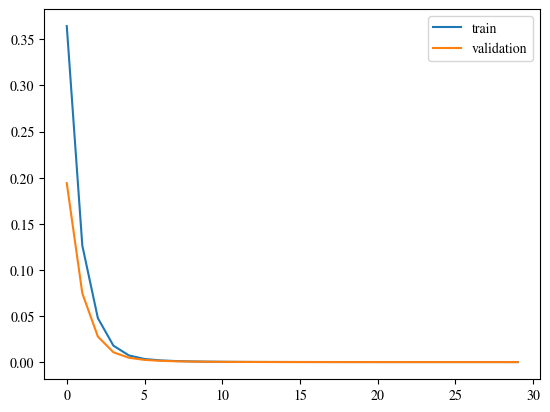

In [134]:
# plot the lost
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

# SEE HOW PREDICTIONS MATCH THE REAL DATA

In [137]:
# see some predictions
y_pred = model.predict(X_test)

# Des normalize the data (ENRIQUEEEE HAZLOOOO TU)


  1/228 [..............................] - ETA: 10s

228/228 [==============================] - 4s 17ms/step


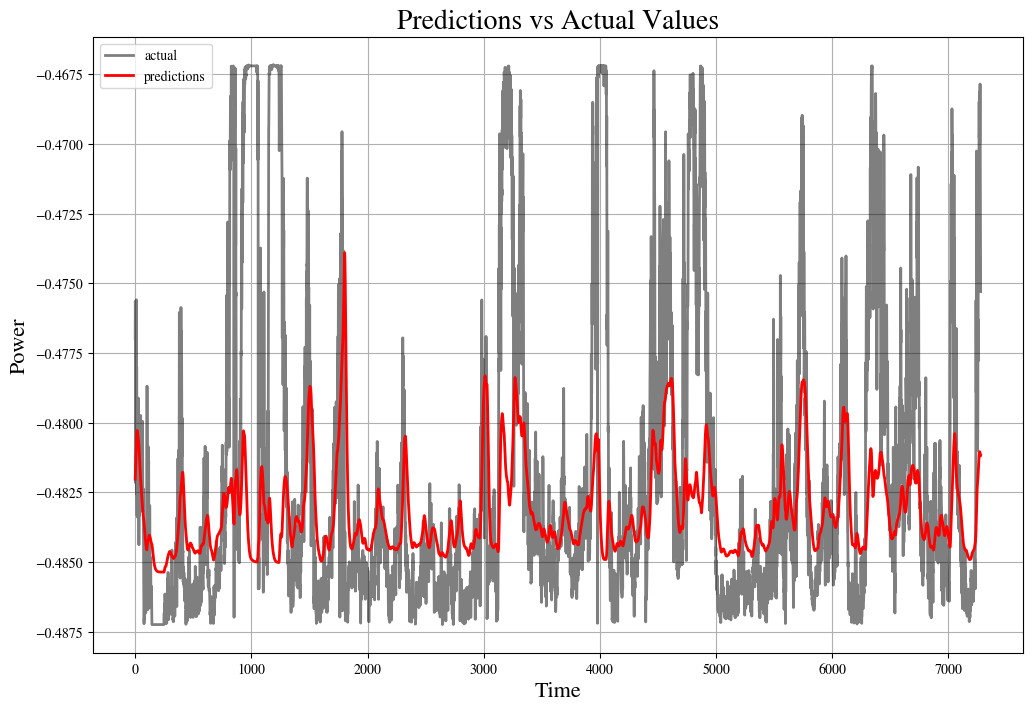

In [143]:

# plot the predictions
plt.figure(figsize=(12,8))

plt.plot(y_test, 'k',label='actual', linewidth=2, alpha=0.5)
plt.plot(y_pred,'-r', label='predictions', linewidth=2)
plt.grid(True)

plt.title('Predictions vs Actual Values', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Power', fontsize=16)

plt.legend()

## MASKING THE NANs AS TUFFE

In [ ]:
# Generate train and test sets
train_size = int(len(V52) * 0.8)
test_size = len(V52) - train_size

train, test = V52.iloc[0:train_size], V52.iloc[train_size:len(V52)]


print(train.shape, test.shape)


In [ ]:
pad_value = 999

train[np.isnan(train)] = pad_value
test[np.isnan(test)] = pad_value

In [ ]:
# packag for ignore warnings
import warnings
warnings.filterwarnings('ignore')

f_colums = ['ActPow', 'ActPow_std']    # X columns
 
# For easy standardization of the data
f_transformer = RobustScaler()
power_transformer = RobustScaler()


# Transform the train and test
f_transformer = f_transformer.fit(train[f_colums].to_numpy())  # Fit for standardization of X
power_transformer = power_transformer.fit(train[['ActPow']])   # Fit for standardization of Y

# Apply to the train and test
train.loc[:, f_colums] = f_transformer.transform(train[f_colums].to_numpy())
train['ActPow'] = power_transformer.transform(train[['ActPow']])

test.loc[:, f_colums] = f_transformer.transform(test[f_colums].to_numpy())
test['ActPow'] = power_transformer.transform(test[['ActPow']])

In [ ]:
TIME_STEPS = 144 # Venga lets take a hole day

# Now create the acrual training and test sequences

X_train, y_train = create_sequences(train[['ActPow', 'ActPow_std']], train['ActPow'], time_steps=TIME_STEPS)
X_test, y_test = create_sequences(test[['ActPow', 'ActPow_std']], test['ActPow'], time_steps=TIME_STEPS)

In [ ]:
# Print the shape to see if everything is ok
# [samples, time_steps, n_features]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
pad_value = 999
no_features = 2

model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))

# First LSTM layer with L2 regularization
model.add(LSTM(50,
               return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_initializer='random_uniform',
               bias_initializer='zeros',
               kernel_regularizer=l2(0.01),  # L2 regularization
               dtype='float32'))

# Activation layer
model.add(Activation('relu'))


# Second LSTM layer with L2 regularization
model.add(LSTM(10,
               activation='relu',
               kernel_regularizer=l2(0.01),  # L2 regularization
               dtype='float32'))


# Output Layer
model.add(Dense(1, activation='linear'))

In [ ]:
# comile the model to be ready for training
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
                    X_train, y_train, 
                    epochs=30,
                    batch_size=300,
                    validation_split = 0.2,  # para validar el modelo sin utilizar los datos de train
                    shuffle=False
                     )

In [ ]:
# plot the lost
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

In [ ]:
# see some predictions
y_pred = model.predict(X_test)

# Des normalize the data (ENRIQUEEEE HAZLOOOO TU)

# plot the predictions
plt.figure(figsize=(10,8))

plt.plot(y_test, 'k', label='actual', linewidth=2)
plt.plot(y_pred,'-r', label='predictions', linewidth=2)
plt.grid(True)

plt.title('Predictions vs Actual Values', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Power', fontsize=16)

plt.legend()